# Zagadki

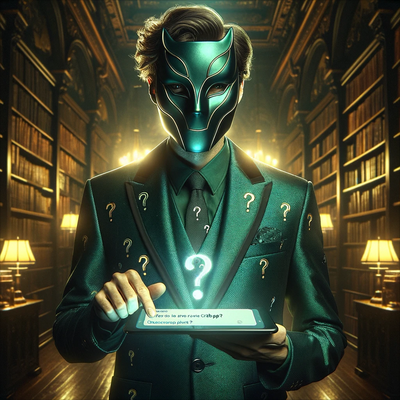

## Wstęp
Zagadki od wieków fascynują ludzi, pobudzając ich umysły do kreatywnego i logicznego myślenia. Od prostych łamigłówek po głębokie zagadki filozoficzne, stanowią one nie tylko formę rozrywki, ale również sztukę rozumienia języka i logicznego wnioskowania. W tym zadaniu będziesz rozwiązywał/a zagadki, polegające na odgadnięciu słowa na podstawie opisu. Wszystkie zagadki wymyślił ChatGPT (ale nie powiemy, która dokładnie wersja i w jaki sposób zachęcona), stąd niektóre mogą być trochę dziwne... Szacujemy, że ludzie są w stanie rozwiązać poprawnie trochę ponad 60% z nich. A jak dobry będzie Twój program?

## Zadanie
Napisz funckję `answer_riddle` która rozwiąże podaną na wejściu zagadkę. Rozwiązaniem jest zawsze jedno słowo. Przykładowe zagadki:

- **zagadka:** kobieta podróżująca środkiem transportu, np. samolotem, pociągiem, statkiem <br>
  **odpowiedź:** pasażerka
- **zagadka:** emocjonalne uczucie łączące dwie osoby, oparte na zaufaniu, szacunku, trosce i oddaniu<br>
  **odpowiedź:** miłość


Naszym kryterium będzie `odwrócona średnia harmoniczna` ([Mean Reciprocal Rank](https://en.wikipedia.org/wiki/Mean_reciprocal_rank)), która działa w następujący sposób: <br>
Jeżeli na zwróconej przez Twoją funkcję liście znajdzie się prawidłowa odpowiedź, otrzymasz wówczas punkty: dokładnie $\frac{1}{k}$ punktów, gdzie $k$ jest pozycją słowa na liście. W szczególności, jeżeli Twój program zgadnie słowo (czyli umieści je na pierwszej pozycji), to otrzymasz 1 punkt. Ostatecznym kryterium jest uśredniona liczba punktów ze wszystkich zagadek.

Powyższe kryterium jest zaimplementowane poniżej przez nas.

## Ograniczenia
- Twoje finalne rozwiązanie będzie testowane w środowisku **bez** GPU.
- Twoja funkcja powinna działać na tyle szybko, aby program był w stanie udzielić odpowiedzi na 100 zagadek w maksymalnie 2 minuty bez użycia GPU.

## Dane
Dane dostępne dla Ciebie w tym zadaniu to:
* `zagadki_do_testow_clean.txt` - około 2000 przykładowych zagadek
* `plwiktionary_definitions_clean.txt` -  plik z definicjami słów wziętymi z [pl.wiktionary.org](https://pl.wiktionary.org/wiki/pl). Z wszystkich definicji z pl.wiktionary.org wzięliśmy definicje 8094 najbardziej popularnych rzeczowników (częstości liczone zgodnie z korpusem https://2018.poleval.pl/index.php/tasks#task3). Uwaga: poprawne rozwiązanie każdej zagadki znajduje się w tym pliku!

* `superbazy_clean.txt` - formy bazowe polskich słów, przygotowane na podstawie projektu https://github.com/morfologik/polimorfologik

* Wektory osadzeń słów bazowych, wytrenowane modelem Word2Vec z biblioteki Gensim, na korpusie PolEval 2018 Task3

## Uwagi i wskazówki
- Dla każdej zagadki, Twoja funkcja powinna zwrócić listę słów (co najwyżej 20), w kolejności od najbardziej (wg Twojego programu) prawdopodobnej odpowiedzi na zagadkę, do najmniej.
- Twoje rozwiazanie bedzie testowane bez dostepu do internetu

## Pliki Zgłoszeniowe
Tylko ten notebook.

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`. Za pomocą skryptu `validation_script.py` będziesz upewnić się, że Twoje rozwiązanie zostanie prawidłowo wykonane na naszych serwerach oceniających. 

Za to zadanie możesz zdobyć pomiędzy 0 i 1.5 punktu. Zdobędziesz 0 punktów jeśli wartość kryterium `mean reciprocal rank` na zbiorze testowym wyniesie poniżej 0.02, a 1.5 punktu jeśli wyniesie powyżej 0.3. Pomiędzy tymi wartościami, wynik rośnie liniowo z wartością kryterium.

# Kod startowy

In [1]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################
FINAL_EVALUATION_MODE = False
# W czasie sprawdzania Twojego rozwiązania, zmienimy tę wartość na True
# Wartość tej flagi M U S I zostać ustawiona na False w rozwiązaniu, które nam nadeślesz!

In [2]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import nltk
from nltk.tokenize import word_tokenize as tokenize
from collections import defaultdict as dd
import math
from gensim.models import Word2Vec
import gdown
import random
import os
from tqdm import tqdm

## Ładowanie danych

In [3]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
path_to_data = 'data/'

bases = {}
# Dictionary mapping words to their base words
all_word_definitions = dd(list)
# Dictionary containing all base words inverse document frequency
base_idf = dd(int)

In [4]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def get_word_base(word):
    global bases
    word = word.lower()
    ret = bases.get(word)
    if ret:
        return ret
    return word

In [5]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if not FINAL_EVALUATION_MODE:
    if not os.path.exists(f"{path_to_data}/zagadki/w2v_polish_lemmas.model") \
        or not os.path.exists(f"{path_to_data}/zagadki/w2v_polish_lemmas.model.syn1neg.npy") \
        or not os.path.exists(f"{path_to_data}/zagadki/w2v_polish_lemmas.model.wv.vectors.npy"):
            gdown.download_folder(url="https://drive.google.com/drive/folders/1P72og_ORfL3Ojf27n-g06DT0ENduPy8C?usp=sharing", output=f"./{path_to_data}")
    nltk.download('punkt')

Retrieving folder contents


Processing file 1dCYKzdg6TihyckNM9Zxr1g9lWT1BzDXI plwiktionary_definitions_clean.txt
Processing file 1q6Ki5Y66gugM30oFcCtJj7ocMJymskSk superbazy_clean.txt
Processing file 1GZPNIR16bxFnzvbIYDLacn8TcKwiGnIh w2v_polish_lemmas.model
Processing file 1C-V5TgIAHUJp_FLD-bvks6LmMkrfQpzC w2v_polish_lemmas.model.syn1neg.npy
Processing file 1RY0Ftfx_-nPUbddYCvHq9p8yCcXbUrYS w2v_polish_lemmas.model.wv.vectors.npy
Processing file 18wrF9VyESTvIT9Z_TqUd_2wV4lP2As3t zagadki_do_testow_clean.txt


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1dCYKzdg6TihyckNM9Zxr1g9lWT1BzDXI
To: /home/witolddrzewakowski/Dokumenty/ioai/OlimpiadaAI/zagadki/data/zagadki/plwiktionary_definitions_clean.txt
100%|██████████| 1.59M/1.59M [00:00<00:00, 27.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1q6Ki5Y66gugM30oFcCtJj7ocMJymskSk
To: /home/witolddrzewakowski/Dokumenty/ioai/OlimpiadaAI/zagadki/data/zagadki/superbazy_clean.txt
100%|██████████| 43.7M/43.7M [00:01<00:00, 29.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GZPNIR16bxFnzvbIYDLacn8TcKwiGnIh
To: /home/witolddrzewakowski/Dokumenty/ioai/OlimpiadaAI/zagadki/data/zagadki/w2v_polish_lemmas.model
100%|██████████| 40.8M/40.8M [00:01<00:00, 33.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1C-V5TgIAHUJp_FLD-bvks6LmMkrfQpzC
From (redirected): https://drive.google.com/uc?id=1C-V5TgIAHUJp_FLD-bvk

In [6]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
for x in open(f'{path_to_data}/zagadki/superbazy_clean.txt'):
    word,base = x.lower().split()
    bases[word] = base

In [7]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
model = Word2Vec.load(f'{path_to_data}/zagadki/w2v_polish_lemmas.model') 

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
for x in open(f'{path_to_data}/zagadki/plwiktionary_definitions_clean.txt'):
    word, definition = x.split('###')
    L = word.split()
    if len(L) == 1:
        word = L[0]       
            
        definition = set(tokenize(definition.lower()))
        all_word_definitions[word].append(definition)
        for word in set(definition):
            base_idf[get_word_base(word)] += 1


for base in base_idf:
    base_idf[base] = -math.log(base_idf[base] / len(all_word_definitions))

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
answers = []
queries = []

with open(f'{path_to_data}/zagadki/zagadki_do_testow_clean.txt') as file:
    for line in file:
        line = line.replace(';;', '').split()                  
        answers.append(line[0])
        queries.append(tokenize(' '.join(line[1:])))

## Kod z kryteriami oceniającymi

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def mean_reciprocal_rank(real_answers, computed_answers, K=20):
    positions = []

    for real_answer, computed_answer in zip(real_answers, computed_answers):
        if real_answer in computed_answer[:K]:
            pos = computed_answer.index(real_answer) + 1
            positions.append(1/pos)
    
    mrr = sum(positions) / len(real_answers)
    print ('Mean Reciprocal Rank =', mrr)
    
    return mrr

# Twoje rozwiązanie

To jest jedyna sekcja, w której musisz coś zrobić.

In [ ]:
def answer_riddle(riddle, K):
    return random.sample(all_word_definitions.keys(), K)

# Ewaluacja

Poniższy kod będzie służył ewaluacji rozwiązania. Po wysłaniu rozwiązania do nas zostanie wykonana funkcja `evaluate_algorithm(score_function, queries, answers, K)`, t.j. prawie identyczny kod jak niżej będzie się uruchamiał na katalogu danych `test_data` dostępnym tylko dla sprawdzających zadania.

Upewnij się przed wysłaniem, że cały notebook wykonuje się od początku do końca bez błędów i bez ingerencji użytkownika po wykonaniu polecenia `Run All`.

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def evaluate_algorithm(score_function, queries, answers, K):
    computed_answers = []
    for query in tqdm(queries, desc="queries answered"):
        computed_answers.append(score_function(set(query), K=K))
    score = mean_reciprocal_rank(answers, computed_answers, K=K)
    
    return score

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if not FINAL_EVALUATION_MODE:
    PART_OF_DATA = 100
    K = 20
    valid_queries = queries[:PART_OF_DATA]
    valid_answers = answers[:PART_OF_DATA]
    score = evaluate_algorithm(answer_riddle, valid_queries, valid_answers, K=K)
    print(f"Score: {score}")